### Entities Extraction

In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... amod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


### Extract Relations

In [2]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


### Import Libraries

In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

### Read Data

In [4]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [6]:
# Let’s inspect a few sample sentences
candidate_sentences['sentence'].sample(5)

1563                               the odia language film industry operates in bhubaneswar and cuttack.
2948    the digital intermediate process was used to achieve a very specific, slightly spoiled palette.
1090                                      that formulation has since been supplanted by improved films.
1946                                      neil nitin mukesh and john abraham make extended appearances.
1073                              occasionally, prints of films considered lost have been rediscovered.
Name: sentence, dtype: object

In [7]:
# Let’s check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence.

doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


### Entity Pairs Extraction

In [8]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:
# Let’s test this function on a sentence
get_entities("the film had 200 patents")

['film', '200  patents']

In [10]:
# Now we can use this function to extract these entity pairs for all the sentences in our data
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:35<00:00, 121.22it/s]


In [11]:
# The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'quicksilver  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'selene  gallio'],
 ['singer', 'sequel']]

### Relation / Predicate Extraction

In [12]:
#For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate.

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [13]:
# Let’s test this function on a sentence

get_relation("John completed the task")

'completed'

In [14]:
# Now let’s get the relations from all the Wikipedia sentences

relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:34<00:00, 126.43it/s]


In [15]:
# Let’s take a look at the most frequent relations or predicates that we have just extracted

pd.Series(relations).value_counts()[:50]

is               357
was              288
released on       80
are               72
were              69
include           63
's                39
released          37
became            31
become            28
composed by       28
has               27
have              27
released in       23
included          20
been              19
made              18
considered        18
called            17
used              17
had               17
be                17
produced          16
scheduled         15
received          15
hired             14
directed by       14
set               14
introduced in     13
went              13
written by        12
produced by       12
wanted            12
sold              12
wrote             11
won               11
began             10
includes          10
began in          10
cast as           10
gave              10
stars             10
directed           9
shot in            9
opened             9
reported           9
produced in        9
features     

### Build a Knowledge Graph

In [16]:
# We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities)

# Let’s create a dataframe of entities and predicates

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [17]:
# Next, we will use the networkx library to create a network from this dataframe. 
# The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.
# It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. 
# For example, “John eats pasta”

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

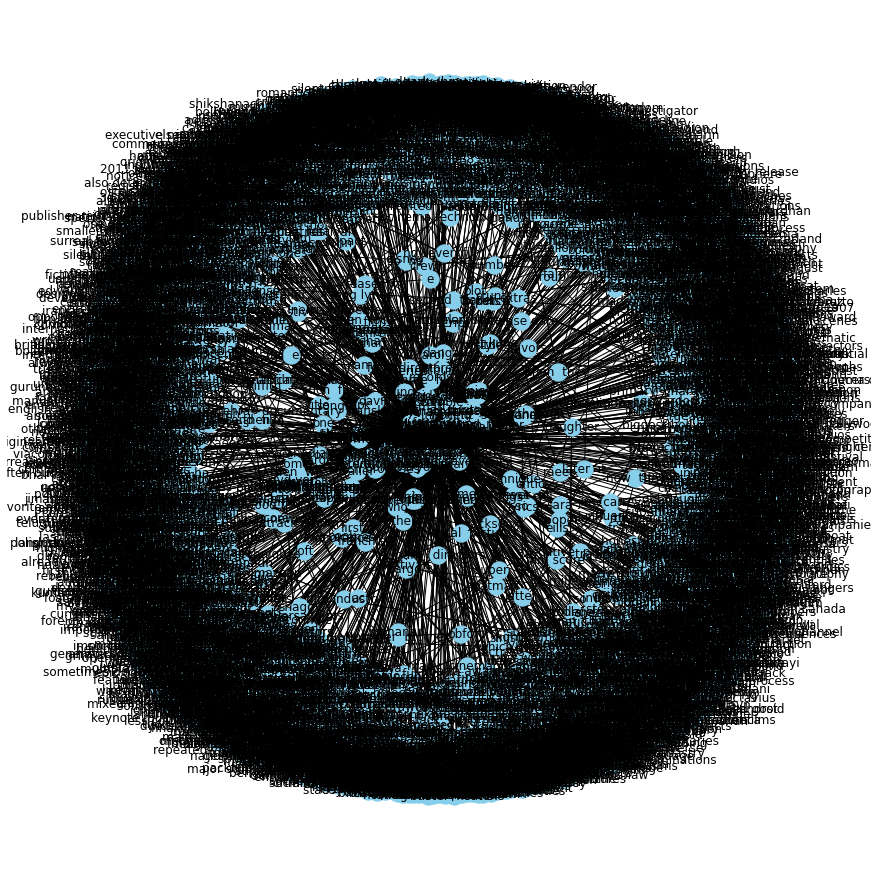

In [18]:
# Let’s plot the network

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

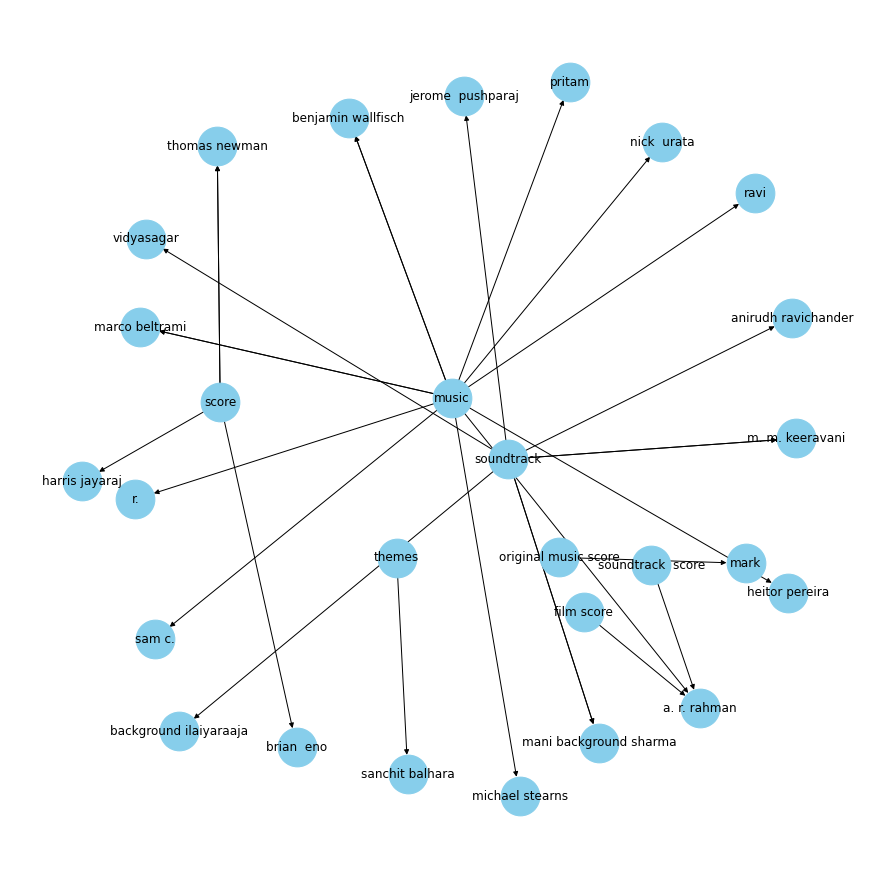

In [19]:
# So, it’s advisable to use only a few important relations to visualize a graph. 
# Let’s start with the relation “composed by”

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


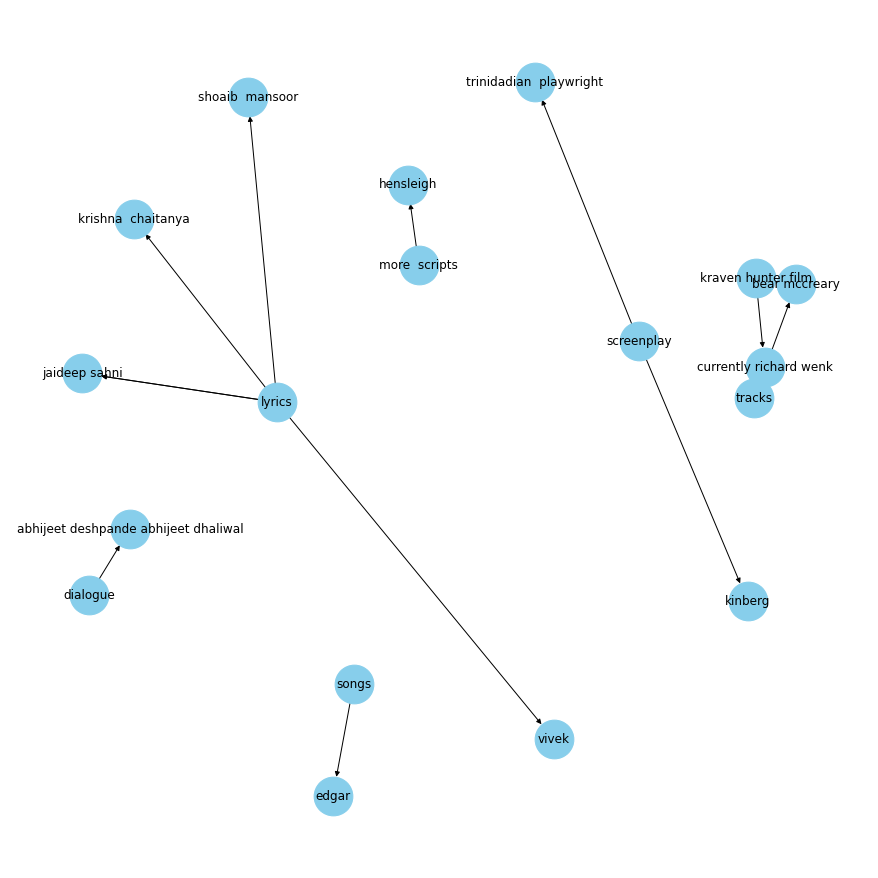

In [20]:
# Let’s check out a few more relations

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

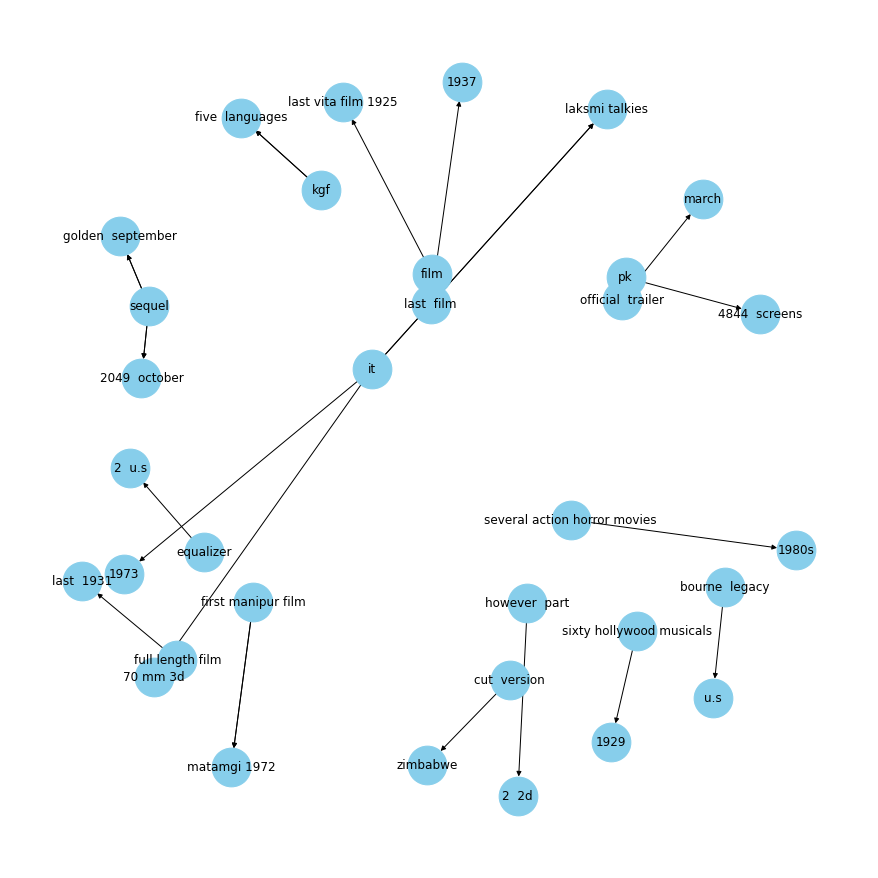

In [21]:
# Let’s see the knowledge graph of another important predicate, i.e., the “released in”

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()